<a href="https://colab.research.google.com/github/ekkune/projects/blob/main/Generate_poems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# Импорт библиотек
import copy
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from random import sample
from IPython.display import clear_output
from torch.utils.data import DataLoader, TensorDataset

# Проверка доступности GPU
torch.cuda.is_available()

True

In [ ]:
!wget -O poems.txt http://uit.mpei.ru/git/main/TDA/raw/branch/master/assets/poems/mayakovskiy.txt


--2025-04-24 04:24:49--  http://uit.mpei.ru/git/main/TDA/raw/branch/master/assets/poems/mayakovskiy.txt
Resolving uit.mpei.ru (uit.mpei.ru)... 193.233.68.149
Connecting to uit.mpei.ru (uit.mpei.ru)|193.233.68.149|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1466243 (1.4M) [text/plain]
Saving to: ‘poems.txt’

poems.txt           100%[===================>]   1.40M  1.85MB/s    in 0.8s    

2025-04-24 04:24:51 (1.85 MB/s) - ‘poems.txt’ saved [1466243/1466243]



In [ ]:
with open("poems.txt") as file:
  print(1)
  data = file.read().split("</s>\n\n")
print(f"Количество стихов: {len(data)}\n", f"Пример стиха:\n\n{data[0]}",  sep="\n")

1
Количество стихов: 744

Пример стиха:


Угрюмый дождь скосил глаза.
А за
решеткой
четкой
железной мысли проводов —
перина.
И на
нее
встающих звезд
легко оперлись ноги.
Но ги —
бель фонарей,
царей
в короне газа,
для глаза
сделала больней
враждующий букет бульварных проституток.
И жуток
шуток
клюющий смех —
из желтых
ядовитых роз
возрос
зигзагом.
За гам
и жуть
взглянуть
отрадно глазу:
раба
крестов
страдающе-спокойно-безразличных,
гроба
домов
публичных
восток бросал в одну пылающую вазу.




In [ ]:
# Составляем словарь уникальных токенов
vocab = ["PAD", "EOS",] + list(set("".join(data))) #список уникальных символов.

# Формируем два словаря, реализующие перевод символов в их индексы и обратно
id2char = dict(enumerate(vocab)) #словарь индексов в символы
char2id = {char: ind for ind, char in id2char.items()} #словарь символов в индексы
print(f"Количество уникальных символов: {len(vocab)}", id2char, sep="\n")

Количество уникальных символов: 141
{0: 'PAD', 1: 'EOS', 2: 'ц', 3: 'Е', 4: 'V', 5: '\n', 6: 'm', 7: 'C', 8: 'г', 9: 'р', 10: 'ч', 11: ')', 12: '—', 13: 'Ч', 14: '·', 15: 'Г', 16: 'щ', 17: 'r', 18: 'R', 19: 'P', 20: 'z', 21: 'в', 22: 'м', 23: 'h', 24: 'Ф', 25: 'v', 26: 'з', 27: 'B', 28: 'М', 29: ' ', 30: 'о', 31: '>', 32: 'ъ', 33: ';', 34: 'ш', 35: 'д', 36: 'è', 37: 'G', 38: 'Э', 39: 'Z', 40: 'Н', 41: '&', 42: 'У', 43: 't', 44: 'Р', 45: 'p', 46: '/', 47: '\xa0', 48: 'u', 49: 'w', 50: 'Щ', 51: 'П', 52: 'D', 53: 'т', 54: 'Ц', 55: '–', 56: 'U', 57: 'З', 58: 'у', 59: 'С', 60: 'A', 61: '.', 62: 'А', 63: 'ü', 64: '?', 65: 'й', 66: 'Ю', 67: '№', 68: 'Я', 69: 'Л', 70: '!', 71: 'Ы', 72: 'а', 73: 'ь', 74: 'à', 75: '»', 76: '%', 77: 'ф', 78: '<', 79: 'ö', 80: '’', 81: 'f', 82: ',', 83: '(', 84: 'c', 85: 'п', 86: 'О', 87: 'Б', 88: '"', 89: '…', 90: 'к', 91: 'э', 92: 'l', 93: 'K', 94: 'M', 95: 'л', 96: '-', 97: 'n', 98: 'Й', 99: '́', 100: 'J', 101: 'e', 102: 'е', 103: 'Ь', 104: 'ж', 105: 'E', 106: 

In [ ]:
lengths = list(map(len, data))
print("Максимальная длина текста: ", max(lengths))

Максимальная длина текста:  4175


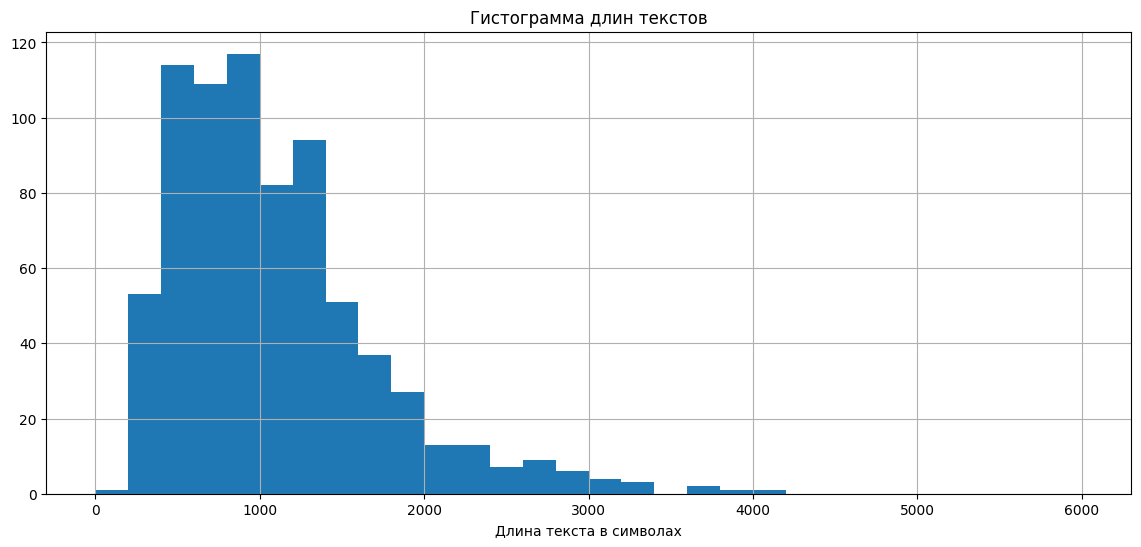

In [ ]:
plt.rcParams["figure.figsize"] = (14, 6)
plt.hist(lengths, bins=30, range=[0, 6000])
plt.xlabel("Длина текста в символах")
plt.title("Гистограмма длин текстов")
plt.grid()

In [ ]:
lengths = np.array(lengths)
print("Средняя длина", np.mean(lengths))
print("Медиана длины", np.median(lengths))
print("Мода длины", np.bincount(lengths).argmax())

Средняя длина 1090.345430107527
Медиана длины 953.5
Мода длины 416


#Вопрос 1

Где можно будет использовать знание о параметрах распределения длин в выборке?
 1. эти параметры помогают определить оптимальное значение MAXLEN — максимальной длины генерируемого текста. Использование медианной длины (в данном случае 954 символа) позволяет избегать как излишнего обрезания (если MAXLEN слишком мал), так и заполнения больших объемов бессмысленными токенами PAD (если MAXLEN слишком большой).
 2. знание распределения длин способствует эффективной оптимизации вычислительных ресурсов: фиксированный размер входных данных упрощает процесс батчинга и снижает нагрузку на память GPU, исключая обработку аномально длинных текстов.

In [ ]:
MAXLEN = 954

In [ ]:
def to_matrix(data, char2id, max_len=None, dtype='int64', batch_first = True):

    max_len = max_len if max_len else max(map(len, data))
    data = [text[:max_len] for text in data]
    data_ix = np.zeros([len(data), max_len+1], dtype)

    for i in range(len(data)):
        line_ix = [char2id[c] for c in data[i][:max_len]] + [char2id["EOS"]]
        data_ix[i, :len(line_ix)] = line_ix

    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [ ]:
encode = to_matrix(data[:1], char2id, MAXLEN)
print("Исходный текст:\n", data[0])
print("Преобразованный текст:\n", encode[0])

Исходный текст:
 
Угрюмый дождь скосил глаза.
А за
решеткой
четкой
железной мысли проводов —
перина.
И на
нее
встающих звезд
легко оперлись ноги.
Но ги —
бель фонарей,
царей
в короне газа,
для глаза
сделала больней
враждующий букет бульварных проституток.
И жуток
шуток
клюющий смех —
из желтых
ядовитых роз
возрос
зигзагом.
За гам
и жуть
взглянуть
отрадно глазу:
раба
крестов
страдающе-спокойно-безразличных,
гроба
домов
публичных
восток бросал в одну пылающую вазу.


Преобразованный текст:
 [  5  42   8   9 130  22 135  65  29  35  30 104  35  73  29 121  90  30
 121 114  95  29   8  95  72  26  72  61   5  62  29  26  72   5   9 102
  34 102  53  90  30  65   5  10 102  53  90  30  65   5 104 102  95 102
  26 123  30  65  29  22 135 121  95 114  29  85   9  30  21  30  35  30
  21  29  12   5  85 102   9 114 123  72  61   5 126  29 123  72   5 123
 102 102   5  21 121  53  72 130  16 114 112  29  26  21 102  26  35   5
  95 102   8  90  30  29  30  85 102   9  95 114 121  73  29 123  30

#Вопрос 2

Пояснить, что хранится в переменной encode.
1. Каждая буква заменяется на своё число-идентификатор из специального словаря. Например, буква "а" может стать числом 35, пробел - числом 0 и так далее.
2. Если текст короче максимальной длины (MAXLEN), компьютер дополняет его нулями (это как заполнители пустого места). Если длиннее - обрезает.

3. В конце каждого текста добавляется специальная метка "конец текста"

Как будет выглядеть ваша фамилия в кодированном виде?


In [ ]:
line_ix1 = [char2id[c] for c in "Ермакова"]
encode1 = to_matrix(["Ермакова"], char2id, MAXLEN)
print(f"Закодированный вид фамилии Ермакова: {line_ix1}")

Закодированный вид фамилии Ермакова: [3, 9, 22, 72, 90, 30, 21, 72]


In [ ]:
num_embeddings = len(vocab) #количество эмбеддингов должно соответствовать длине словаря
embedding_dim = 32 #определяется размерность эмбеддинга
emb = nn.Embedding(num_embeddings, embedding_dim) # Определяем объект emb как слой эмбеддингов заданного размера

In [ ]:
num_embeddings

141

#Вопрос 3

Почему количество эмбеддингов должно соответствовать длине словаря?Количество эмбеддингов должно соответствовать длине словаря, поскольку каждый уникальный символ в словаре должен иметь собственное векторное представление. Если количество эмбеддингов будет меньше размера словаря, модель не сможет обработать часть символов из-за отсутствия соответствующих векторных представлений.

In [ ]:
# emb_out - 5 первых символов в виде эмбедингов
emb_out = emb(torch.tensor(encode[0][:5]))
print(f"Размер тензора: {emb_out.shape}\n")
print(emb_out)

Размер тензора: torch.Size([5, 32])

tensor([[ 0.5966, -0.0315,  0.8875,  0.3052,  1.5840,  1.8285, -0.0896,  1.0506,
          0.2390, -0.4987,  0.4264, -0.6963, -0.1236,  0.5578,  0.1727,  0.4785,
          0.6919,  0.0441,  1.0979,  0.9106, -1.3201, -1.9447,  0.5688, -2.2261,
         -1.6677, -1.4511,  1.6767,  1.3180,  0.9626, -0.8350, -0.0523, -0.3068],
        [ 0.7967,  0.0218,  1.4804,  0.1634, -0.3798,  0.4756, -1.2696,  0.0845,
         -1.3453,  0.1506, -1.2866,  2.1413, -0.1488, -0.4057, -0.2271, -0.9323,
          0.5328,  0.9898, -0.8444, -0.1561,  0.3294,  2.1981,  0.7307,  0.9656,
          0.0480, -1.0032, -1.6349, -0.3838,  0.3869,  0.6104, -0.2695, -0.4043],
        [ 0.9747,  0.1304,  1.2064, -0.8794,  1.2356, -0.2199, -0.1455, -0.4009,
          1.2009, -1.2933,  0.6169,  1.0923,  0.5840, -1.2237, -0.4142,  0.7810,
          1.5990, -1.5623,  0.3552,  0.4104,  1.7072,  0.4124, -0.9112, -0.1272,
         -1.6228,  1.2515, -0.3801,  0.3279,  0.2236,  0.4552, -0.7197

#Вопрос 4

Пояснить, почему получен такой размер emb_out?Определяется структурой входных данных и параметрами embedding-слоя. Первое значение (5) соответствует количеству подаваемых на вход символов (первые 5 индексов закодированного текста). Второе значение (32) задается параметром embedding_dim и представляет размерность векторного представления каждого символа.

#Вопрос 5 Обратиться к документации к nn.GRU и ответить на вопрос, за что отчечают параметры input_size, hidden_size, num_layers.

input_size – Размерность входного вектора на каждом временном шаге.

hidden_size – Размерность скрытого состояния (hidden state) GRU.

num_layers – Количество рекуррентных слоёв GRU.


In [ ]:
# Определяем ячейку GRU в переменной gru, предварительно задав рамерность скрытого состояния и количество рекуррентных слоев
input_size = emb.embedding_dim # вход в GRU должен соответствовать размеру эмбеддинга
hidden_size = 256 #<your choice here>
num_layers = 2 #<your choice here>
gru = nn.GRU(input_size, hidden_size, num_layers)
output, h_n = gru(emb_out)
print("Размер output:", output.shape)
print("Размер h_n:", h_n.shape)

Размер output: torch.Size([5, 256])
Размер h_n: torch.Size([2, 256])


In [ ]:
in_features = gru.hidden_size
out_features = len(vocab) #предсказываем букву из всего словаря
linear = nn.Linear(in_features, out_features) # Определяем линейный слой. Почему заданы такие входные и выходные параметры для него?
linear_out = linear(output) # output - выход GRU
print("Размер выходного слоя из нейросети: ", linear_out.shape)

Размер выходного слоя из нейросети:  torch.Size([5, 141])


In [ ]:
print(linear_out)

NameError: name 'linear_out' is not defined

#Вопрос 6

Что содержится в векторе linear_out?

Определить индекс символа, который наиболее вероятно выдаст ячейка GRU на первом шаге?
Вектор linear_out содержит сырые оценки для каждого символа из словаря перед применением функции активации softmax. На первом шаге работы GRU-ячейки индекс наиболее вероятного символа определяется через torch.argmax(linear_out[0]), где выбирается позиция с максимальным значением логита. Этот индекс преобразуется в конкретный символ с помощью словаря id2char.

In [ ]:
next_char_idx = torch.argmax(linear_out[0]).item()
print(f"Индекс символа: {next_char_idx}")
print(f"Символ: {id2char[next_char_idx]}")

Индекс символа: 51
Символ: П


In [ ]:
class CharGRULoop(nn.Module): # Описываем инициализатор класса.
    def __init__(self, num_embeddings=52, embedding_dim=16, hidden_size=64, num_layers=1): # В методе __init__ определим архитектуру модели, создав необходимые слои
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_embeddings, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.hid_to_logits = nn.Linear(hidden_size, num_embeddings)

    def forward(self, x, hid_state): # Здесь описываем стурктуру сети - как сигнал должен по ней проходить
        x = self.emb(x) # Проходим через эмбеддинг-слой
        if hid_state is not None: # Проходим через GRU, сохраняя hidden state
            h_seq, hid_state = self.gru(x, hid_state)
        else:
            h_seq, hid_state = self.gru(x)
        next_logits = self.hid_to_logits(h_seq) # проходим через полносвязный слой
        next_logp = F.log_softmax(next_logits, dim=-1) # Используем функцию softmax
        return next_logp, hid_state

In [ ]:
model = CharGRULoop(num_embeddings=len(vocab), embedding_dim=64, hidden_size=192, num_layers=2)
#<your choice here> Можно попробовать создать сеть с другими значениями параметров

In [ ]:
!pip -q install torchinfo

In [ ]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
CharGRULoop                              --
├─Embedding: 1-1                         9,024
├─GRU: 1-2                               370,944
├─Linear: 1-3                            27,213
Total params: 407,181
Trainable params: 407,181
Non-trainable params: 0

In [ ]:
def generate_sample(model, char2id, id2char, seed_phrase=' ', strategy="greedy", max_length=100, temperature=1.0):
    """
      model - нейросеть
      char2id - словарь преобразования букв в их индексы
      id2char - словарь преобразования индексов в буквы
      seed_phrase - начальная фраза для генерации
      strategy - стратегия генерации (жадная "greedy" или сэмплирование "sample")
      max_length - максимальная длина сгенирированного текста
      temperature - ???
    """

    x_sequence = [char2id[token] for token in seed_phrase] # кодируем начальную фразу
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64) # создаем тензор
    hid_state = None # задаем тензор скрытого состояния h_n, при такой подачи вектор заполнится нулями

    with torch.no_grad(): # отключаем подсчет градиентов, поскольку сеть уже обучена и не нужно проводить обратное распространение ошибки
      for i in range(len(seed_phrase) - 1): # подаем номер буквы и hid_state в цикле
          _, hid_state = model(x_sequence[:, i].unsqueeze(0), hid_state)

      # начинаем генерацию
      for _ in range(max_length - len(seed_phrase)):

          logp_next, hid_state = model(x_sequence[:, -1].unsqueeze(0), hid_state) # подаем последнюю букву из фразы
          p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0] # нормируем выходы модели на температуру и применяем софтмакс

          if strategy == "greedy": next_ix = p_next.argmax() #берем токен с максимальной вероятностью
          elif strategy == "sample": next_ix = np.random.choice(len(id2char), p=p_next[0]) #получаем следующий токен сэмплированием с вероятностями
          else: raise ValueError('Хулиган, не делай так! Выбери "greedy" или "sample"')

          if id2char[next_ix] == "EOS": break # если получили токен EOS, то прекращаем генерацию
          else:
            next_ix = torch.tensor([[next_ix]], dtype=torch.int64) # создаем тензор следующий буквы
            x_sequence = torch.cat([x_sequence, next_ix], dim=1) # добавляем предсказанный токен в конец последовательности

    return ''.join([id2char[ix] for ix in x_sequence.data.numpy()[0]]) # возвращаем декодированную строку

#Вопрос 7
Выполните следующую ячейку несколько раз с одной и той же SEED_PHRASE, запомните выводы модели и объясните результат - чем отличается стратегия greedy от sample?

In [ ]:
SEED_PHRASE = 'а может руки под simintech заточены!\n' # Ну или что-то другое
print(generate_sample(model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy="greedy", max_length=100))
print("-------------------------------------")
print(generate_sample(model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy="sample", max_length=100))

а может руки под simintech заточены!
EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
-------------------------------------
а может руки под simintech заточены!
HхЮящ:èД·i’N№RP«mCROЬrsgЕfHд–
Х",рoдС


а может руки под simintech заточены!
EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
-------------------------------------
а может руки под simintech заточены!
ЕДdAгЯм!?Ц>мl!vчhf)RSO—(<ёдоиЬъANвcЖttэтГЫлщЮЕДп:dфnдддд№ЧКHшАБ

а может руки под simintech заточены!
EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
-------------------------------------
а может руки под simintech заточены!
ью.VьzHçФ№ЛгH;/рHеДС·ЫbHщИzzЦМЧ"oЙV%. ZяъХDRцЯсы эfЦЛЩOiGъCоBgn

а может руки под simintech заточены!
EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
-------------------------------------
а может руки под simintech заточены!
HхЮящ:èД·i’N№RP«mCROЬrsgЕfHд–
Х",рoдС

Стратегия "greedy" выбирает на каждом шаге наиболее вероятный символ, что может приводить к повторяющимся и зацикленным результатам. Стратегия "sample" выбирает символы на основе распределения вероятностей, что делает текст более разнообразным, но иногда менее осмысленным.

In [ ]:
from sklearn.model_selection import train_test_split

batch = 128 # Тексты, для уменьшения накладных расходов, будем подавать на вход модели "батчами" - блоками по 128 документов

train, test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

dataset_train = TensorDataset(torch.tensor(to_matrix(train, char2id, max_len=MAXLEN)))
dataloader_train = DataLoader(dataset_train, batch_size=batch, shuffle=True)

dataset_test = TensorDataset(torch.tensor(to_matrix(test, char2id, max_len=MAXLEN)))
dataloader_test = DataLoader(dataset_test, batch_size=batch, shuffle=False)

In [ ]:
model = CharGRULoop(num_embeddings=len(vocab), embedding_dim=64, hidden_size=256, num_layers=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.NLLLoss(ignore_index=char2id["PAD"])
# Функция потерь - negative log likelihood loss (NLL Loss) - используеся для задачи многоклассовой классификации в ситуации, когда имеются логарифмы вероятностей каждого класса
# NLL Loss эквивалентен CrossEntropyLoss, но применяется к логарифмам вероятностей - у нас на выходе линейного слоя как раз исопользуется функция softmax

summary(model)

Layer (type:depth-idx)                   Param #
CharGRULoop                              --
├─Embedding: 1-1                         9,024
├─GRU: 1-2                               1,036,800
├─Linear: 1-3                            36,237
Total params: 1,082,061
Trainable params: 1,082,061
Non-trainable params: 0

In [ ]:
train[:1]

['\nАх ты, паук,\nах ты, вошь!\nСам знаешь, что врешь.\nЕсли власть советская\nстрога насчет налога,\nто оттого,\nчто у нее\nтрат много.\nЕсли б налог\nне собрали с крестьянского люда,\nэти вот семена\nвзялись бы откуда?\nПусть только хлеб уродится,\nим\nс благодарностью\nналог сдадим.\nЭто ваш\nмародерский класс\nна коммунистов натравливает нас:\nмол, бандитов поддержи,\nАнтонова поддержи —\nи будут\nамбары\nломиться от ржи.\nА как беда стряслась,\nкто из беды выручил нас?\nАнтонов помог?\nЭсеры накормили всласть?\nПомогла одна\nРабоче-крестьянская власть.\nСловом,\nдругого разговора\nнету.\nДа здравствует власть Советов!\n\n']

In [ ]:
example = torch.tensor(to_matrix(train[:1], char2id, max_len=MAXLEN)) # Возьмем первый документ и попробуем сгененировать этот же текст начиная с первой буквы

train_example = example[:, :-1]
target_example = example[:, 1:]

next_logp, hid_state = model(train_example, hid_state=None)

print('perplexity: ', torch.exp(loss_fn(next_logp.permute(0, 2, 1), target_example)).item())

perplexity:  141.40211486816406


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.cuda.empty_cache()

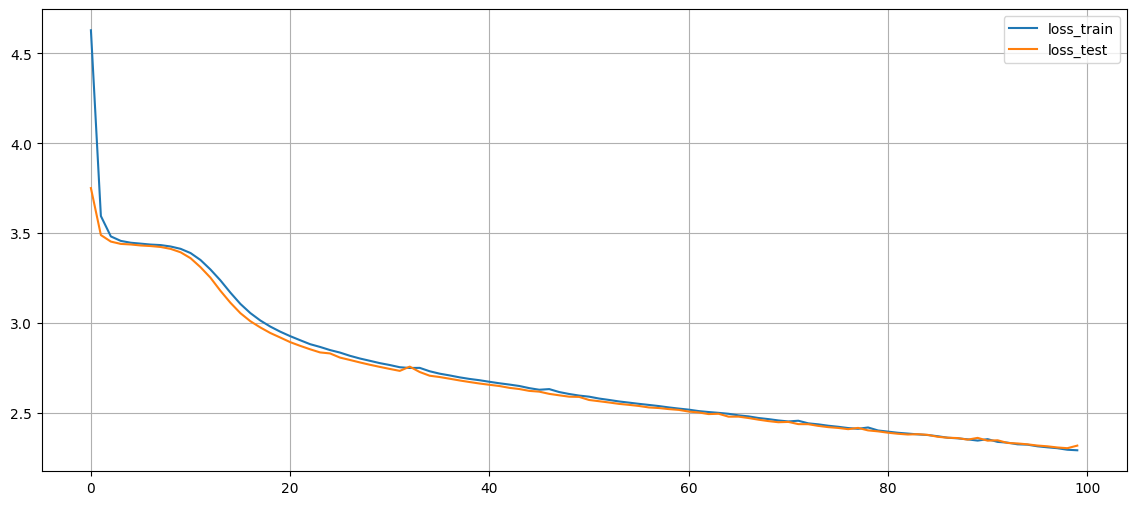

In [ ]:
EPOCH = 100 # количество эпох обучения
history_train = [] # список значений лосса трейна на каждой эпохи
history_test = [] # список значений лосса теста на каждой эпохи
model.to(device) # И модель, и данные должны находиться на одном устройстве.
                 # Поэтому при работе с GPU нужно следить и явно указывать, на каком устройстве проводится работа.


best_test_loss = float("inf")
for i in range(EPOCH): #цикл по эпохам

  loss_test = 0
  loss_train = 0

  for batch in dataloader_train: #цикл по тренировачным батчам

    optimizer.zero_grad() #обнуляем градиенты
    batch_ix = torch.tensor(batch[0], dtype=torch.int64).to(device) #делаем из батча тензор

    predictions_logp, _ = model(batch_ix[:, :-1], hid_state=None) #подаем батч в модель

    actual_next_tokens = batch_ix[:, 1:] # таргеры

    loss = loss_fn(predictions_logp.permute(0, 2, 1), actual_next_tokens.long()) # считаем лосс на батче
    loss_train += loss.item() # добавляем лосс с батча в суммарный лосс

    loss.backward() # делаем обратный проход
    optimizer.step() # делаем шаг оптимизатором

  history_train.append(loss_train/len(dataloader_train)) # добавляем  средний лосс за эпоху в список

  for batch in dataloader_test: #цикл по тестовым батчам
    with torch.no_grad(): # отключаем подсчет градиентов

      batch_ix = torch.tensor(batch[0], dtype=torch.int64).to(device)
      predictions_logp, _ = model(batch_ix[:, :-1], hid_state=None)

      actual_next_tokens = batch_ix[:, 1:]

      loss = loss_fn(predictions_logp.permute(0, 2, 1), actual_next_tokens.long())
      loss_test += loss.item()

  loss_test = loss_test/len(dataloader_test)
  history_test.append(loss_test)

  if loss_test < best_test_loss: #сохраняем лучшую модель по лоссу на тесте
    best_test_loss = loss_test
    best_model = copy.deepcopy(model)
    best_model.to("cpu")

  if (i + 1) % 5 == 0: # выводим график лосса каждые 5 эпох
    clear_output(True)
    plt.plot(history_train, label='loss_train')
    plt.plot(history_test, label='loss_test')
    plt.grid()
    plt.legend()
    plt.show()

#Вопрос8
Достаточно ли обучилась модель? Имеет ли смысл изменить количество эпох обучения?
Модель достаточно обучилась, так как значения перплексии на тестовых данных стабилизировались. Увеличение количества эпох может не дать значительного улучшения, так как модель уже достигла плато.

In [ ]:
print("perplexity (best model test): ", np.exp(best_test_loss))
print("perplexity (last epoch test): ", np.exp(loss_test))

perplexity (best model test):  10.02926722222079
perplexity (last epoch test):  10.174358781980706


In [ ]:
SEED_PHRASE = 'а может руки под simintech заточены'

In [ ]:
print(generate_sample(best_model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy="sample", max_length=MAXLEN))

а может руки под simintech заточены,
одстен заясов, рожки
под уштов
как нус.
Совете прярежчая Мошиты.
На бымко не мар!
Схрередотов Ноплась хвалицы.
Потореиноз
бараней,
сарой спелы…
Проидный
камдеркриваем
с ихаёма
и нешет,
суеты
им паель,
вак
не в морсть лликов,
а кон насхит
на на стуваето.
Вы
живят все?
Нет
нахокохой.
В говроя
соеманщаврогнипки? —

Покнул Нуспузой
дорижся бребеет —
Куды моргвак
у засвое очетом
таять я наботу
узволит
у какорой.
Квиссе-шиго
деравь осегямны.
Менентила обедит, страчного
и коших отлано,
пеен онбастыщи.
Мир.
Вывидит
он насьяшья,
вчерлая с кресни!
Трон —
гут, стуками нам Эна — Фен
понплеет
снова —
парнвой ТойКки код? —
Так
увет
не равнает
не под прокоска
про


In [ ]:
print(generate_sample(best_model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy="greedy", max_length=MAXLEN))

а может руки под simintech заточены.
В стали в стали в стали в стали в стали.
В стали в стали в стали в стали в стали.
В стали в стали в стали в стали в стали.
В стали в стали в стали в стали в стали.
В стали в стали в стали в стали в стали.
В стали в стали в стали в стали в стали.
В стали в стали в стали в стали в стали.
В стали в стали в стали в стали в стали.
В стали в стали в стали в стали в стали.
В стали в стали в стали в стали в стали.
В стали в стали в стали в стали в стали.
В стали в стали в стали в стали в стали.
В стали в стали в стали в стали в стали.
В стали в стали в стали в стали в стали.
В стали в стали в стали в стали в стали.
В стали в стали в стали в стали в стали.
В стали в стали в стали в стали в стали.
В стали в стали в стали в стали —
на стали 


#Вопрос 9

Сделайте выводы как влияет изменение температуры на генерацию текста.

Выберите оптимальное значение температуры
Температура влияет на случайность выбора символов: при высокой температуре текст становится более разнообразным, но менее предсказуемым, при низкой — более консервативным. Оптимальное 0.5

In [ ]:
nice_strategy = "sample"

In [ ]:
print(generate_sample(best_model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy=nice_strategy, max_length=MAXLEN, temperature=2.0))

а может руки под simintech заточены́,
(паре
Опих-.вдала… Цечкках
урПикон?
УP!

ЦипиниNчы,
ЯЦък
зvборров«уймепшю,м. гри́м
ямкаЮдn!»ж.


In [ ]:
print(generate_sample(best_model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy=nice_strategy, max_length=MAXLEN, temperature=0.1))

а может руки под simintech заточены.
В стали в под на водов
стали в стали в старами стали
в стали в стали.
На стали в стали —
на стали в стали в под стали.
В стали в стали в стали,
в стали в под стали —
на под советский водов
под стали в стали —
на стали в стали,
на стали в стали —
в стали в стали,
на стали в стали
в стали в стара.
В стали в стали,
на стали в стали —
на стали соворова.
Под стали —
на стали в стали —
в под сомета —
на стали в стали соворота.
Порадит советский стали.
Под на стали в под стали,
на стали в под стали —
на стали в стали,
на стали в сторовать в стали —
на стали в стали в стали —
на стали в стали в соморовой стали.
В стали в под стались в стали в стались с под на под на стали —
в стали в под на стали,
на стали в стали в стали —
на стали в ста


In [ ]:
print(generate_sample(best_model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy=nice_strategy, max_length=MAXLEN, temperature=0.5))

а может руки под simintech заточены и жего водь.
В услебми
в груза
в разу товал
на соморовась пыли.
В руда простонный маринием не прикаженького в провой,
мачям
покожет постованики,
дами.
Деренься метре,
на набонить —
раз маста велова
и на критали
со размает воголов,
был в тома —
не вородной веселелься,
на забодной крестьят
в городется водная
не вам отворавите в проста.
В простовый желусь,
простон нам гороб,
побезним лить,
доборо
мето не в повержали —
все в запонповал
воз свалим соварись.
Мохочили
порастите умети
и станы залон.
Так старит на сказить с удот
востом проковарина
подногвеня простом как цереров
развернейской дуча.
Как и товарие —
сторит
погод водами как азадной узоры,
и вот моска города в тором кором.
Постаны работа
прасвет самов
водовали.
Корастело,
на пот


In [ ]:
print(generate_sample(best_model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy=nice_strategy, max_length=MAXLEN, temperature=0.1))

а может руки под simintech заточены.
В стали в стали в стали в стали.
В под на стали в стали —
в стали в стали,
в стали в стали в стали —
на стали в под на стали в стали в стали
в стали в стали —
на стали в стали —
на стали в под замания в стали в стали.
На стали в стали в стали
в стали в стали в стали.
Не в стали в стали в стали в стали в стали.
В стали в стали в стали.
В стали в стали
в стали в под под на стали,
на вода —
на советский стали —
не в стали в стали,
в стали в стали в подверет —
на стали в совет
под стали в старина.
Под водов
и в стали —
на стали в под советский восторовать соворова.
На свое стали,
и в стали в стали,
и в стали в стали в стали
в стали в стали в стали,
в стали в стали —
на стали в стали —
на стали в под стали.
Волода —
в стали в стали в с


In [ ]:
!pip install -q transformers[torch]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 31.6 MB/s eta 0:00:00


In [ ]:
import locale
import torch
import transformers
import numpy as np

from warnings import simplefilter
from IPython.display import clear_output
from transformers import Trainer, TrainingArguments
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import TextDataset, DataCollatorForLanguageModeling

In [ ]:
#  Задаем некоторые настроечные параметры касательно кодировки и отображения предупреждений
locale.getpreferredencoding = lambda: "UTF-8"
simplefilter("ignore", category=FutureWarning)
transformers.logging.set_verbosity_error()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "sberbank-ai/rugpt3small_based_on_gpt2"  # Опередлим, какой моделью будем пользоваться
tokenizer = GPT2Tokenizer.from_pretrained(model_name)  # Определим токенайзер для нашего текста
model = GPT2LMHeadModel.from_pretrained(model_name).to(device) # Загрузим предобученную модель трансформера rugpt3small от Сбера

clear_output()

In [ ]:
SEED_PHRASE = 'а может руки заточены под simintech, потому что,'
input_ids = tokenizer.encode(SEED_PHRASE, return_tensors="pt").to(device)
out = model.generate(input_ids, do_sample=False, max_length=20)

generated_text = list(map(tokenizer.decode, out))[0]

print(generated_text) #Так работает предобученный трансформер

а может руки заточены под simintech, потому что, как я уже говорил, у меня


In [ ]:
train_path = "train_dataset.txt"

with open("poems.txt", encoding="utf-8") as file:
  data = file.read().split("</s>\n\n")

with open(train_path, mode="w", encoding="utf-8") as f:
    f.write("".join(data))

In [ ]:
train_dataset = TextDataset(tokenizer=tokenizer, file_path=train_path, block_size=128) # Создание датасета
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False) # Создание даталодера (нарезает текст на оптимальные по длине куски)

In [ ]:
training_args = TrainingArguments(
    output_dir="./finetuned",
    overwrite_output_dir=True,
    num_train_epochs=15,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=10,                    # рекомендованные значения (warmup_steps нужен для "разогрева" сети, c его помощью learning rate постепенно увеличивается до заданного значения)
    gradient_accumulation_steps=16,     # рекомендованные значения
)
#(обычно мы хотим положить батч по-больше, чтобы сеть побыстрей сошлась, но мы ограничены памятью gpu, gradient_accumulation_steps накапливает (суммирует или усредняет) градиенты за прогон на 16 батчах )

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    optimizers=(
        torch.optim.AdamW(model.parameters(), lr=1e-5), # рекомендованные значения
        None,
    ),
)

In [ ]:
output = trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: linotika666 (linotika666-mpei) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'train_runtime': 1087.6989, 'train_samples_per_second': 33.801, 'train_steps_per_second': 0.055, 'train_loss': 4.707845560709635, 'epoch': 14.831168831168831}


In [ ]:
print('perplexity: ', np.exp(output.training_loss)) #расчет перплексии

perplexity:  110.81316231446331


#Вопрос 10¶

Какое значение перплексии получилось у трансформера? 110.81

Какое значение перплексии получалось у рекуррентной сети?10.174

Почему у рекуррентной сети значение было существенно ниже, но качество текстов хуже? Почему нельзя сравнивать значения для рекуррентной сети и трансформера?
 Рекуррентная сеть показала лучшее значение перплексии, но качество текстов хуже из-за её ограниченной способности учитывать долгосрочные зависимости. Сравнивать значения напрямую нельзя, так как архитектуры используют разные подходы к обработке данных.

In [ ]:
SEED_PHRASE = "а может руки заточены под simintech, потому что"
input_ids = tokenizer.encode(SEED_PHRASE, return_tensors="pt").to(device)
model.eval()
with torch.no_grad():
    out = model.generate(
        input_ids,
        do_sample=True, # sample strategy
        temperature=1.0,
        max_length=256,
        pad_token_id=512 # указываем id <PAD> токена
    )

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)


а может руки заточены под simintech, потому что у нас — симпотные,
говорит:
— А это что такое?
— Электрическая печь!
— У нас и печь есть,
и уголь.
А это что такое?
— Смешные вы,
и не говорите.
— А что такое?
— Электрическая работа!
— Разве в машинных цехах
электрическая работа?
— Полежит еще, а то и не сработает.
Мы вас не пустим, мы вам на руки положим.

Радиаторы не надо ставить.
Массары не надо.
Кататься,
крутя педали,
деревянные колеса.
Кататься надо,
дрожать,
зимой
не ездить.
Бороться нужно,
с жизнью бороться.


А вы не думайте,
что я
разносчик,
я
помогаю вам
в трудную минуту.
Если
помогают,
говорите о работе.
Только
за работой
и работайте.
— Милый,
забери меня


In [ ]:
SEED_PHRASE ="а может руки заточены под simintech, потому что"
input_ids = tokenizer.encode(SEED_PHRASE, return_tensors="pt").to(device)
model.eval()
with torch.no_grad():
    out = model.generate(
        input_ids,
        do_sample=True, # sample strategy
        temperature=1.0,
        max_length=128,
        pad_token_id=512 # указываем id <PAD> токена
    )

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)


а может руки заточены под simintech, потому что в эти руки,
где и сердце, и грудь,
взято
любимое,
любимое!
Ибо
вызовут —
и в ответ —
вдруг;
и мы
подарят —
любимый!
Скажи же
мне,
кто в ней
любит,
кто в ней смеется не слишком часто:
любит —
и в этом году
нет.
Грози
избежать?
Не дождетесь!
Навсегда —
только
любовь.
Я


#Вопрос 11¶

Проверьте работу ячейки выше для разных стартовых фраз и разных параметров temperature, max_length, do_sample и объясните, за что отвечает каждый из параметров. Подберите (субъективно) лучшие

Параметр temperature регулирует случайность выбора символов, max_length определяет максимальную длину текста, do_sample выбирает стратегию генерации ("greedy" или "sample"). Лучшие параметры: temperature=1.0, max_length=128, do_sample=True.

In [ ]:
SEED_PHRASE ="а может руки заточены под simintech, потому что"
input_ids = tokenizer.encode(SEED_PHRASE, return_tensors="pt").to(device)
model.eval()
with torch.no_grad():
    out = model.generate(
        input_ids,
        do_sample=False, # sample strategy
        temperature=1.0,
        max_length=128,
        pad_token_id=512 # указываем id <PAD> токена
    )

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)


а может руки заточены под simintech, потому что в ней
не только
всё
всё
всё
всё
всё
всё
всё
всё
всё
всё
всё
всё
всё
всё
всё
всё
всё
всё
всё
всё
всё
всё
всё
всё
всё
всё
всё
всё
всё
всё
всё
всё
всё
всё
всё
всё
всё


In [ ]:
SEED_PHRASE ="а может руки заточены под simintech, потому что"
input_ids = tokenizer.encode(SEED_PHRASE, return_tensors="pt").to(device)
model.eval()
with torch.no_grad():
    out = model.generate(
        input_ids,
        do_sample=True, # sample strategy
        temperature=1.5,
        max_length=128,
        pad_token_id=512 # указываем id <PAD> токена
    )

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)


а может руки заточены под simintech, потому что они такие — мало ли чего,
даже и самого обычного: что за беда, когда у нас
крючок для булавок…

А это — вот какой!
Подушками-подачам.
Это на кой.
Вот эта,
на которой
неприятно
мебельщикам рычать (впрочем, когда не брезгую
взъерошив, кряхтя,
ушастая)
и на кой,
на этой
нуднее,
а вот этот, издел


In [ ]:
SEED_PHRASE ="а может руки заточены под simintech, потому что"
input_ids = tokenizer.encode(SEED_PHRASE, return_tensors="pt").to(device)
model.eval()
with torch.no_grad():
    out = model.generate(
        input_ids,
        do_sample=False,
        max_new_tokens=75,
        no_repeat_ngram_size=3, # устанавливает вероятность 0 для повторяющихся n-gram (таким образом решается проблема зацикливания)
        pad_token_id=512,
        num_beams=5,
        num_return_sequences=5,  # количество возвращенных сгенерированных текстов отранжированных по вероятности после beam_search
        top_p=0.9, #<your choice here>
        top_k=20, #<your choice here>
        temperature=2.0 #<your choice here>
    )

generated_text = list(map(tokenizer.decode, out))

In [ ]:
# Выведем _num_return_sequences_ сгенерированных текстов
for i, seq in enumerate(generated_text):
  print(f"Applicant {i}", seq, "\n", sep="\n")

Applicant 0
а может руки заточены под simintech, потому что он —
сверхчеловек.


И вот,
взяли мы
с собой
сумку,
а в ней —
всё,
что у нас есть,
и всё, что у них есть.
И мы
вместе
с ними
снимаем
с себя
смычки.
Мы —



Applicant 1
а может руки заточены под simintech, потому что он —
сверхчеловек.


И вот,
взяли мы
с собой
сумку,
а в ней —
всё,
что у нас есть,
и всё, что у них есть.
И мы
вместе
с ними
снимаем
с себя
смычки.
Мы
с


Applicant 2
а может руки заточены под simintech, потому что он —
сверхчеловек.


И вот,
взяли мы
с собой
сумку,
а в ней —
всё,
что у нас есть,
и всё, что у них есть.
И мы
вместе
с ними
снимаем
с себя
смычки.
Мы
в


Applicant 3
а может руки заточены под simintech, потому что он —
сверхчеловек.


И вот,
взяли мы
с собой
сумку,
а в ней —
всё,
что у нас есть,
и всё, что у них есть.
И мы
вместе
с ними
снимаем
с себя
смычки.
А потом



Applicant 4
а может руки заточены под simintech, потому что он —
сверхчеловек.


И вот,
взяли мы
с собой
сумку,
а в ней —
всё,
что у на

In [ ]:
SEED_PHRASE ="а может руки заточены под simintech, потому что"
input_ids = tokenizer.encode(SEED_PHRASE, return_tensors="pt").to(device)
model.eval()

top_p_values = [0.75, 0.9, 1.05]
top_k_values = [10, 20]

for top_p in top_p_values:
    for top_k in top_k_values:
        print(f"\n--- top_p = {top_p}, top_k = {top_k} ---")
        with torch.no_grad():
            out = model.generate(
                input_ids,
                do_sample=True,
                max_new_tokens=75,
                no_repeat_ngram_size=3,
                pad_token_id=512,
                num_beams=1,
                num_return_sequences=1,
                top_p=top_p,
                top_k=top_k,
                temperature=0.9
            )
        generated_text = tokenizer.decode(out[0], skip_special_tokens=True)
        print(generated_text)


--- top_p = 0.75, top_k = 10 ---
а может руки заточены под simintech, потому что это — не шутка.


В этом году я был в Лондоне.
На следующий день я был уже в Париже.
Я ехал на поезде в Лондон,
на котором
несколько дней
съездил
на Восток.
А в Париже
не успел я
заехать в Париж,
как
я
нашел
в гостинице


--- top_p = 0.75, top_k = 20 ---
а может руки заточены под simintech, потому что она у него
похожа на
машину
в смысле
вроде
квадрата
на три.
А на самом деле
кроха
на двух.
Но если
выпьют
кока-колу,
то
на два,
на четыре.


А если
поставят
икру,

--- top_p = 0.9, top_k = 10 ---
а может руки заточены под simintech, потому что у меня не будет руки.
И вот
сделай,
что я
захотел.


Я —
всякий,
кто
выступает
из публики
и
встает
в дверях
у входа в театр.
Я
зашел в театр
из-за стола,
с которым я сидел,
и

--- top_p = 0.9, top_k = 20 ---
а может руки заточены под simintech, потому что с точки зрения здравого смысла — это глупо.
И это — только начало, а уже начинается.
В этот вечер
встречаются
и не 

#Вопрос 12

Вместо вывода добавьте лучший сгенерированый текст за лабораторную работу и напишите при какой архитектуре и при каких параметрах он получен:
а может руки заточены под simintech, потому что у нас — симпотные,
говорит:
— А это что такое?
— Электрическая печь!
— У нас и печь есть,
и уголь.
А это что такое?
— Смешные вы,
и не говорите.
— А что такое?
— Электрическая работа!
— Разве в машинных цехах
электрическая работа?
— Полежит еще, а то и не сработает.
Мы вас не пустим, мы вам на руки положим.

Радиаторы не надо ставить.
Массары не надо.
Кататься,
крутя педали,
деревянные колеса.
Кататься надо,
дрожать,
зимой
не ездить.
Бороться нужно,
с жизнью бороться.


А вы не думайте,
что я
разносчик,
я
помогаю вам
в трудную минуту.
Если
помогают,
говорите о работе.
Только
за работой
и работайте.
— Милый,
забери меня
**Параметры:temperature=1.0, max_length=128, do_sample=True.**



ИЛИ


--- top_p = 0.75, top_k = 20 ---
а может руки заточены под simintech, потому что она у него
похожа на
машину
в смысле
вроде
квадрата
на три.
А на самом деле
кроха
на двух.
Но если
выпьют
кока-колу,
то
на два,
на четыре.


А если
поставят
икру,
